# Train a variational autoencoder to perform clustering on the MNIST data set. Part 4.

With this exercises I'm trying to learn the basics of training an ANN with Keras.

The objective is to construct a VAE and pre-train it on the MNIST data set, then add a layer that performs clustering on the embeddings and fine-tune the model balancing the three losses:
- Reconstruction loss (ensure that it extracts good latent features, so we can reconstruct the input from the embeddings).
- KL-divergence loss (ensure that the mebeddings follow a mixture of gaussians distribution, so that we can infer some mining on the latent space and are able to generate new images).
- Clustering loss (ensure that we achieve good clustering quality).

---

**In this fourth part,** I will construct a simpler CVAE based on a simple MPL instead of a CNN network. I will pre-train the model setting the clustering loss weight to 0, as if the layer wasn't there. Then, I will set it to 0.1 to fine-tune the model. I found empirically that this is a good weight value, when set higher the clustering loss tends to eclipse the KL-loss and the embeddings tend to form too tight clusters).

The main objective is to write a simpler, clearer model and learn to manage different loss weights for the pre-training and fine-tuning phases.

# Prepare some things...

First, we will import the necessary libraries and the MNIST data set. Then we will define some functions we will reuse from part 1.

## Import libraries

## Load libraries

In [1]:
from tensorflow.keras.datasets import mnist

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import random
from sklearn.cluster import KMeans
import sklearn.metrics

## Load and prepare the MNIST data set

In [2]:
(x_train, y_train), (x_test, y_test) = (mnist.load_data())

In [3]:
x_train = x_train.reshape(-1, 28*28)
x_test = x_test.reshape(-1, 28*28)

x_train = x_train.astype("float")/255
x_test = x_test.astype("float")/255

In [4]:
onehot_train = to_categorical(y_train)
onehot_test = to_categorical(y_test)

## Reuse some functions

In [5]:
def plot_latent_space(z, labels, centroids = None, figsize=(10,10), legend_title = "Labels", alpha=0.2):
    """
    Draw a 2D scatterplot of the latent space
    """
    
    plt.figure(figsize=figsize)
    scatter = plt.scatter(z[:,0], z[:,1], label=labels, c=labels, cmap="tab10", alpha=alpha, linewidths=0)

    if centroids is not None:
        plt.scatter(centroids[:,0], centroids[:,1], c="black", marker="x")
        
    leg = plt.legend(*scatter.legend_elements(), title=legend_title)
    # Make points in legend opaque
    for lh in leg.legendHandles: 
        # lh._legmarker.set_alpha(1) # old version of matplotlib
        lh.set_alpha(1)

    plt.show()

In [6]:
def plot_clusters_vs_labels(z, labels, clusters, centroids = None, figsize=(16,8), alpha=0.2):
    """
    Draw two 2D scatterplots of the latent space side by side 
    to compare the cluster assignments with the original labels
    """
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    
    for ax, lab, title in zip(axes, (clusters, labels), ("Clusters", "Labels") ):
    
        scatter = ax.scatter(z[:,0], z[:,1], label=lab, c=lab, cmap="tab10", alpha=alpha, linewidths=0)

        leg = ax.legend(*scatter.legend_elements(), title=title)
        # Make points in legend opaque
        for lh in leg.legendHandles: 
            # lh._legmarker.set_alpha(1) # old version of matplotlib
            lh.set_alpha(1)
            
        if centroids is not None:
            ax.scatter(centroids[:,0], centroids[:,1], c="black", marker="x")

    plt.tight_layout()

In [7]:
def compare(dataset, encoder, decoder, labels, old_figure=None, n=5):
    """
    Takes the first n images of the dataset, passes them through the encoder and decoder,
    and shows a comparison of the original and reconstructed images.
    
    If an old_figure is passed, it adds a column to it with the new reconstruction. 
    """
    index = np.arange(0,n)
    res = 28
       
    if old_figure is not None:
        assert old_figure.shape[0] == n*res
        figure = np.zeros((old_figure.shape[0], old_figure.shape[1]+res))
        figure[0:old_figure.shape[0], 0:old_figure.shape[1]] = old_figure
    else:
        figure = np.zeros((n*res, 2*res))
        for i in index:
            figure[i*res:(i+1)*res, 0:res] = dataset[i].reshape(res, res)
    
    for i in index:
        z = encoder.predict(dataset[[i]], verbose=0)
        reconstructed = decoder.predict(z, verbose=0).reshape(res, res)
        figure[i*res:(i+1)*res, figure.shape[1]-res:figure.shape[1]] = reconstructed

    plt.figure()
    # plt.axis("off")
    
    x_ticks = np.arange(res/2, figure.shape[1], res)
    assert len(labels) == len(x_ticks)
    plt.xticks(x_ticks, labels, rotation=90)
    plt.yticks([])
    
    plt.imshow(figure, cmap="Greys_r")
    
    return figure

# Construct the model

## Define some variables

Now we can construct the new CVAE model. First, we will declare some variables we will be using later:

In [8]:
res = 28          # Resolution of the MNIST images (they are 28 x 28)
img_dim = res*res # Size of the image once flattened (784). We will use it for the input shape.

latent_dim = 2    # Number of dimensions of the latent space
num_nodes = 256   # Number of nodes of the danse layers (encoder and decoder)

n_clusters = 10   # Number of clusters

## Define custom layers

We will reuse the `Sampler` and `Clustering` subclassed layers we defined in parts 1 and 3, respectively.

There is one difference, though: since we won't define the encoder as a subclassed model, we need to define the KL-loss somewhere else. We could define a new subclassed layer that takes `z_mean` and `z_var_log` from the encoder, computes the loss, and outputs `z_mean` and `z_var_log` as is.

Instead, we will compute and add the loss in the `Sampler` subclass.

In [9]:
class Sampler(layers.Layer):
    def call(self, z_mean, z_log_var):
         
        # Compute the KL loss function
        kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var -
                                       tf.square(z_mean) -
                                       tf.exp(z_log_var),
                                       axis=-1)
        kl_loss = tf.reduce_mean(kl_loss)
        self.add_loss(kl_loss)
        self.add_metric(kl_loss, name="kl_loss")
        
        # Sample from the latent distribution        
        batch_size = tf.shape(z_mean)[0]
        z_size = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch_size, z_size))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon   

In [10]:
class Clustering(layers.Layer):
    def __init__(self, n_clusters, name=None):
        super(Clustering, self).__init__(name=name)
        self.n_clusters = n_clusters

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        # Cluster centroids
        self.clusters = self.add_weight(name='clusters',
                                        shape=(self.n_clusters, input_dim),
                                        trainable=True,
                                       )
   
    def call(self, inputs, training=False):
        """
        Compute cluster assignments:
        
        z = inputs  - - - - - - - - - - - - - - (None, 2)
        mu = self.clusters  - - - - - - - - - - (10, 2)
        
        d_ij = ||z_i - mu_j||^2 - - - - - - - - (None, 10)
        
        q_ij = (1 + d_ij) / Sum_j'(1 + d_ij') - (None, 10)
        
        """
        
        # Taken from https://github.com/Tony607/Keras_Deep_Clustering/blob/master/Keras-DEC.ipynb:
        q = 1.0 / (1.0 + (tf.reduce_sum(tf.square(tf.expand_dims(inputs, axis=1) - self.clusters), axis=2)))
        q = tf.transpose(tf.transpose(q) / tf.reduce_sum(q, axis=1)) # Make sure each sample's 10 values add up to 1.
        
        return q

## Construct the model

Now we can construct the CVAE model using the functional API. We will use a single dense layer on the encoder and the decoder.

In [11]:
# Inputs
encoder_inputs = keras.Input(shape=(img_dim), name="encoder_inputs")

# Encoder
x = layers.Dense(num_nodes, activation="relu") (encoder_inputs)
z_mean = layers.Dense(latent_dim, name="z_mean") (x)
z_log_var = layers.Dense(latent_dim, name="z_log_var") (x)

# Sampler + KL-loss
z = Sampler(name="sampler") (z_mean, z_log_var)

# Decoder
x = layers.Dense(num_nodes, activation="relu") (z)
decoder_outputs = layers.Dense(img_dim, activation="sigmoid", name="dec_out") (x)

# Clustering
clustering_outputs = Clustering(n_clusters=n_clusters, name="clust_out") (z)

In [12]:
# CVAE model
cvae = keras.Model(encoder_inputs, [decoder_outputs, clustering_outputs], name='cvae')
cvae.summary()

Model: "cvae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, 784)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 256)          200960      ['encoder_inputs[0][0]']         
                                                                                                  
 z_mean (Dense)                 (None, 2)            514         ['dense[0][0]']                  
                                                                                                  
 z_log_var (Dense)              (None, 2)            514         ['dense[0][0]']                  
                                                                                               

Also, we construct the encoder and decoder model recycling layers from the full model:

In [13]:
# Encoder model
encoder = keras.Model(encoder_inputs, z_mean, name="encoder")
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_inputs (InputLayer)  [(None, 784)]            0         
                                                                 
 dense (Dense)               (None, 256)               200960    
                                                                 
 z_mean (Dense)              (None, 2)                 514       
                                                                 
Total params: 201,474
Trainable params: 201,474
Non-trainable params: 0
_________________________________________________________________


In [14]:
# Decoder model
decoder = keras.Model(z, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 256)               768       
                                                                 
 dec_out (Dense)             (None, 784)               201488    
                                                                 
Total params: 202,256
Trainable params: 202,256
Non-trainable params: 0
_________________________________________________________________


## Define the loss functions

As in parts 1 and 3, we need to define our custom loss functions:

In [15]:
# Define the custom loss 
def reconstruction_loss(x, y):
    return tf.reduce_sum(keras.losses.binary_crossentropy(x, y))

# Define the custom loss 
def clustering_loss(Q, P):
    return tf.reduce_sum(tf.keras.losses.kld(Q, P))

## Define a function to update P

And we need a function that will take care of updating the auxiliary distribution used to compute the clustering loss:

In [16]:
# Define a function to update the auxiliary distribution
def update_P(Q):
    """
    Compute the auxiliary distirbution P and update it
    
    Q = {q_ij} = soft cluster assignments
    
                      q_ij^2 / f_j
    P = {p_ij} = -------------------------
                  Sum_ij' (q_ij^2 / f_j')

    """
    global P
    
    weight = Q ** 2 / tf.reduce_sum(Q, axis=0)
    P = tf.transpose(tf.transpose(weight) / tf.reduce_sum(weight, axis=1))
    
    # Save as numpy array (not strictly necessary, but easier to debug)
    P = P.numpy()
    print("Auxiliary distribution updated.")
    
def call_update_P(epoch, logs):
    # Called from callbacks
    # Update auxiliary distribution P every N epochs:
    N = 10
    
    if (epoch > 0) and (epoch % N == 0):
        _, Q = cvae.predict(x_train, verbose=0)
        update_P(Q)

# Pre-train the model without clustering
## Initialize a dummy P

We definen the model with a clustering layer since the beginning, so we will need to pass some targets for the clustering layer outputs to the `model.train()` function. Since we won't be using the clustering loss in this phase, we will set two dummy targets (one for the training set and another for the validation set):

In [17]:
dummy_P = np.zeros((len(x_train), n_clusters))
dummy_P_val = np.zeros((len(x_test), n_clusters))

## Define the callbacks

As in part 1, we will stop training if the validation loss does not improve after 10 epochs.

In [18]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=10,
        restore_best_weights=True,
    )
]

## Train the model

Now we can compile our model. We will define a loss function for each model output, and also the weight we want to assign to each one. The KL-loss defined inside the model automatically is assigned a weight of 1.

In [19]:
loss = {"dec_out": reconstruction_loss,
        "clust_out": clustering_loss,
       }

loss_weights = {"dec_out":   1,
                "clust_out": 0,  # Pre-train: clustering loss weight set to 0
               }

cvae.compile(optimizer="adam",
             loss=loss,
             loss_weights=loss_weights,
            )

Also, we define the targets for each output. And we can train the model:

In [ ]:
epochs = 100

targets = {"dec_out": x_train,
           "clust_out": dummy_P,
          }

val_targets = {"dec_out": x_test,
             "clust_out": dummy_P_val,
            }

cvae.fit(x_train, targets,
         epochs=epochs,
         batch_size=128,
         validation_data=(x_test, val_targets),
         callbacks = callbacks,
         verbose=2,
        )

## Save (or load) the model weights

In [ ]:
# cvae.save_weights("models/mpl_cvae/pretrained/weights")

In [20]:
cvae.load_weights("models/mpl_cvae/pretrained/weights")

## Show the embeddings

We can show the embeddings for the training dataset on the generated latent space. It looks that the true labels are better separated than with our CNN based VAE from part 1. Maybe the CNN layers imposed some undesired restrictions?

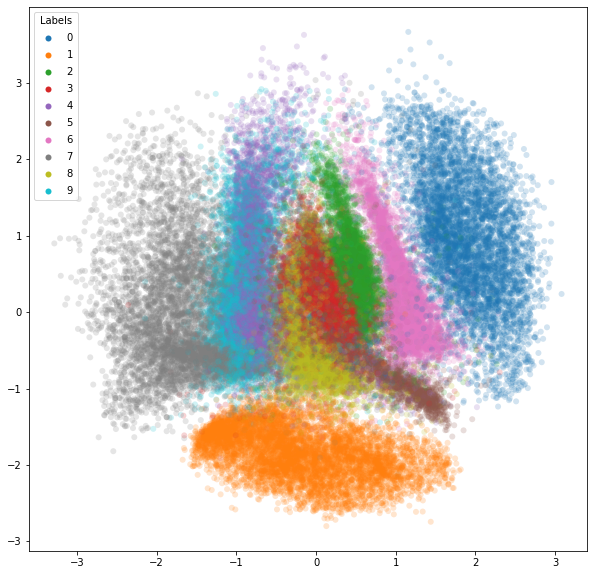

In [21]:
z_train = encoder.predict(x_train, verbose=0)
plot_latent_space(z_train, y_train)

Lets see how well the new model encodes and then decodes some random images.

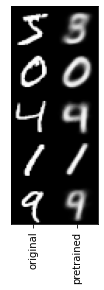

In [22]:
compare_orig_vs_pretrained = compare(x_train, encoder, decoder, ("original", "pretrained"))

# Fine-tune (with clustering)
## Initialize cluster weights and update P

Now that we have our model pre-trained we can activate the clustering layer and fine-tune the whole model.

First, we need to inicialize the auxiliary distribution (to compute the clustering loss function) and the clustering layer weights (the initial centroids). As in part 3, we will use the K-means algorithm to initialize the centroids.

In [23]:
kmeans = KMeans(n_clusters=10, n_init=30)
kmeans.fit(z_train)

KMeans(n_clusters=10, n_init=30)

In [24]:
# Initial auxiliary distribution (labels)
P = np.zeros((len(x_train), n_clusters))
update_P(to_categorical(kmeans.labels_))
# Inicial weights (centroids)
cvae.get_layer(name='clust_out').set_weights([kmeans.cluster_centers_])

Auxiliary distribution updated.


## Train the model

Now we can fine-tune the model. As in part 3, we need to update our callbacks:
- We won't use validaton.
- We want to update the auxiliary distribution P every 10 epochs during training.

In [25]:
callbacks = [
    tf.keras.callbacks.LambdaCallback(
        on_epoch_end=call_update_P,
    )
]

In [26]:
loss_weights = {"dec_out":   1,
                "clust_out": 0.1,  # Fine-tune: clustering loss weight set to 0.1
               }

cvae.compile(optimizer="adam",
             loss=loss,
             loss_weights=loss_weights,
            )

Now we can train the model:

In [ ]:
epochs = 50

targets = {"dec_out": x_train,
           "clust_out": P,
          }

cvae.fit(x_train, 
         targets,
         epochs=epochs,
         # batch_size=128,
         callbacks = callbacks,
         verbose=2,
        )

## Save (or load) the model weights

In [ ]:
# cvae.save_weights("models/mpl_cvae/finetuned/weights")

In [27]:
cvae.load_weights("models/mpl_cvae/finetuned/weights")

## Show the embeddings and clusters

Let's take a look at the new embeddings and the found clusters:

It looks like the clusters got separated from each other and their boundries are fairly well delimited. But they don't correlate at all with the true labels....

In [28]:
z_test = encoder.predict(x_test, verbose=0)
_, c_test = cvae.predict(x_test, verbose=0)
c_test = c_test.argmax(1)

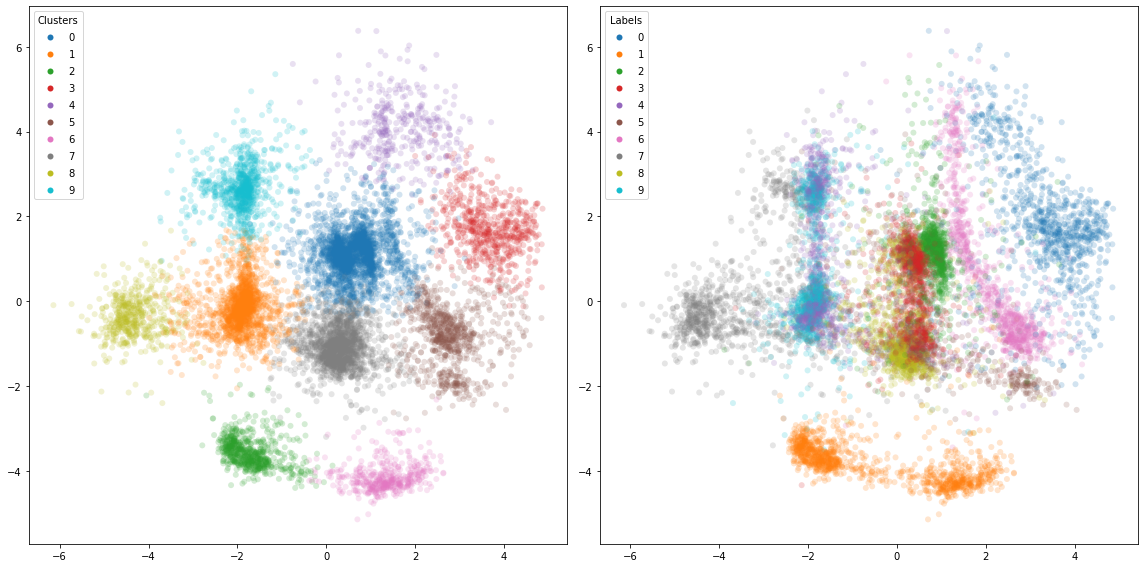

In [29]:
plot_clusters_vs_labels(z_test, y_test, c_test)

Let's see if the model is still able to compress and then reconstruct some random images:

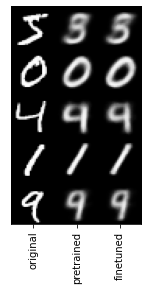

In [30]:
_ = compare(x_train, encoder, decoder, ("original", "pretrained", "finetuned"), compare_orig_vs_pretrained)

## Evaluate the model

We can compute some metrics for the new cluster assignments. We improved a little over the results from part 3, but not much... How could we improve the performance?

Acc: 0.5407
ARI: 0.3163
AMI: 0.5202
Sil: 0.5715


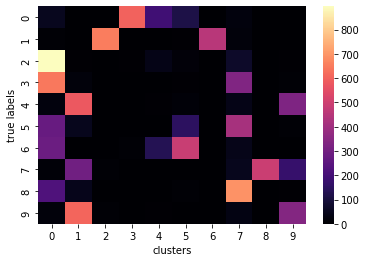

In [31]:
confusion_matrix = sklearn.metrics.confusion_matrix(y_test, c_test)
heatmap = sns.heatmap(confusion_matrix,  cmap='magma')
heatmap.set(xlabel='clusters', ylabel='true labels')

clust_labels = confusion_matrix.argmax(0)[c_test]
print(f"Acc: {sklearn.metrics.accuracy_score(y_test, clust_labels):.4f}")
print(f"ARI: {sklearn.metrics.adjusted_rand_score(y_test, c_test):.4f}")
print(f"AMI: {sklearn.metrics.adjusted_mutual_info_score(y_test, c_test):.4f}")
print(f"Sil: {sklearn.metrics.silhouette_score(z_test, c_test):.4f}")